### Final Propensity matching results

In [1]:
%reset -f

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext Cython

In [3]:
%reload_ext Cython

In [4]:
import sys
sys.path.append('..')
import warnings
def warn(message = None, category=None, stacklevel=1, source=None):
    pass

warnings.warn = warn

In [7]:
import scipy.stats as sts
import pandas as pd
import numpy as np
import time
import datetime as dt
from pathlib import Path
import time
#custom
from data_functions import make_date_to_MYR, make_MYR_to_date
from diabetes_onset import( process_canary,
get_tc, in_canary, diabet_onset, not_first_month_diabetes, 
                           match_data_per_month, 
                           filter_first_month_diabetes,
                           matched_population, 
                           propensity_func,
                           nearest_neighbor_func, 
                           random_matching_func, agglomerative )
import data_process
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import models, layers
import warnings
warnings.filterwarnings('ignore')
from utils import statistics_first_month, p_val, stat_matrices 
from path import col_seq_can_all, col_seq_can 
from sklearn.neighbors import NearestNeighbors
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
np.random.seed(seed = 0)

In [6]:
# #setup cython
# #for cython build if needed -> cd to /modules folder and then run
# %cd ..
# !python3 setup.py build_ext --inplace
# %cd ./causal_data_creation/canary_application/

In [8]:
%config Completer.use_jedi = False

### Load pre matching data

In [9]:
pp_str = 'Pre_Matching_DATA/'
Path("./"+pp_str).mkdir(exist_ok=True)

In [9]:
# %%time
# !aws s3 cp s3://cdphp-s3-us-e-p-pond/rpi/CANARY_PAPER/DATA/Pre_Matching_DATA/treated2.p ./Pre_Matching_DATA/treated2.p; 
# !aws s3 cp s3://cdphp-s3-us-e-p-pond/rpi/CANARY_PAPER/DATA/Pre_Matching_DATA/controls.p ./Pre_Matching_DATA/controls.p;
# !aws s3 cp s3://cdphp-s3-us-e-p-pond/rpi/CANARY_PAPER/DATA/Pre_Matching_DATA/pmpm.p ./Pre_Matching_DATA/pmpm.p;
# !aws s3 cp s3://cdphp-s3-us-e-p-pond/rpi/CANARY_PAPER/DATA/tempHybridSelectionMoreData/random.p ./Pre_Matching_DATA/random.p;

In [45]:
controls = pd.read_pickle(pp_str+'controlsPast.p')

In [10]:
treated = pd.read_pickle(pp_str+'treated2Past2.p')
controls = pd.read_pickle(pp_str+'controlsPast.p')
controls2  = controls[controls['HasPast'] == 1].reset_index(drop = True)
pmpm =pd.read_pickle(pp_str+'pmpm.p')
random_controls = pd.read_pickle(pp_str+'random.p')

In [11]:
pmpm.MBR_GNDR.replace({"F":0,"M":1}, inplace=True)

In [12]:
treated.shape, treated.MYR.min(), treated.MYR.max()

((22364, 92), 201710, 202107)

In [13]:
controls.shape, controls.MYR.min(), controls.MYR.max()

((9582196, 92), 201701, 202107)

In [14]:
pmpm.shape, pmpm.MYR.min(), pmpm.MYR.max()

((9650961, 91), 201701, 202107)

# Check continuity and take average of 1 year history

### Treated

In [18]:
# def get_treated_agg(treated, pmpm):
    
#     #get one year before dates
#     treated_history = pmpm[pmpm.PERS_ID.isin(treated.PERS_ID)]
#     treated.drop(['MEDICAID_LOB'], axis=1, inplace=True)
#     treated['MYR_12'] = treated.MYR.apply(data_process.get_one_year_before, offset_month=12)
    
#     treated_aggregate = pd.DataFrame(columns=col_seq_can_all)
#     for i, (index, row) in tqdm(enumerate(treated.iterrows())):
#         pid = row.PERS_ID
#         myr = row.MYR
#         old_myr = row.MYR_12
#         history = treated_history.query("PERS_ID==@pid & MYR>=@old_myr & MYR<=@myr")
#         agg_data = history[col_seq_can_all].mean()
#         agg_data.PERS_ID = str(int(row.PERS_ID))
#         agg_data.MYR     = int(row.MYR)
#         treated_aggregate = pd.concat([treated_aggregate, pd.DataFrame(agg_data).T], axis=0)
            
#     treated_aggregate.PERS_ID = treated_aggregate.astype(int).astype(str)
#     treated_aggregate.MYR = treated_aggregate.MYR.astype(int)
    
#     treated_aggregate = treated_aggregate.reset_index(drop=True)
    
#     return treated_aggregate
    

In [24]:
# %%time
# treated_aggregate = get_treated_agg(treated.copy(), pmpm.copy())
# treated_aggregate.to_pickle("./Final/Data/Common/treated_aggregated_filtered_final_g.p")

In [22]:
sorted_months = treated.MYR.sort_values().unique()

In [23]:
sorted_months

array([201710, 201711, 201712, 201801, 201802, 201803, 201804, 201805,
       201806, 201807, 201808, 201809, 201810, 201811, 201812, 201901,
       201902, 201903, 201904, 201905, 201906, 201907, 201908, 201909,
       201910, 201911, 201912, 202001, 202002, 202003, 202004, 202005,
       202006, 202007, 202008, 202009, 202010, 202011, 202012, 202101,
       202102, 202103, 202104, 202105, 202106, 202107])

In [16]:
treated_aggregate = pd.read_pickle("./Final/Data/Common/treated_aggregated_filtered_final_g.p") #goes into matching as tr_agg

In [26]:
#controls_aggregate = data_process.get_average_final_record(controls2.copy(), sorted_months, pmpm[col_seq_can_all].copy())
#controls_aggregate.to_pickle("./Final/Data/Common/controls_aggregated_filtered_final_g.p")

In [27]:
controls_aggregate.shape, controls2.shape

In [17]:
controls_aggregate = pd.read_pickle("./Final/Data/Common/controls_aggregated_filtered_final_g.p")

In [29]:
#treated_original = treated[treated.set_index(['PERS_ID','MYR']).index.isin(treated_aggregate.set_index(['PERS_ID','MYR']).index)].reset_index(drop=True)
controls_original = controls2[controls2.set_index(['PERS_ID','MYR']).index.isin(controls_aggregate.set_index(['PERS_ID','MYR']).index)].reset_index(drop=True)

In [30]:
del treated, controls, controls2

In [24]:
# !aws s3 cp ./Final/Data/PCA/treated_aggregated_filtered_final.p s3://cdphp-s3-us-e-p-pond/rpi/nneehal/DATA/Agg_Data_Common/treated_agg.p --acl bucket-owner-full-control
# !aws s3 cp ./Final/Data/PCA/controls_aggregated_filtered_final.p s3://cdphp-s3-us-e-p-pond/rpi/nneehal/DATA/Agg_Data_Common/controls_agg.p --acl bucket-owner-full-control

# Load Model and Pick Columns for Matching

In [31]:
model = models.load_model(pp_str+"TF_Latent_Model_m6_Canary_stacked_logfixed", compile=False)

In [32]:
latent_cols = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16']

In [33]:
onset = "CC_DIABETES"
cols_to_keep = ["PERS_ID", "MYR", 'AGE_AT_MIDMONTH', 'MBR_GNDR',  onset]
extra_cols = ['IP_BIN6', 'ER_BIN6','LOB']

In [34]:
treated_latent = data_process.transform_features_with_NN(model, treated_aggregate[col_seq_can_all].copy(), cols_to_keep, latent_dim=16)
treated_latent1 = treated_original[cols_to_keep+extra_cols]
treated_latent = pd.concat([treated_latent1, treated_latent.loc[:,'x1':]], axis=1)

In [37]:
controls_latent = data_process.transform_features_with_NN(model, controls_aggregate[col_seq_can_all].copy(), cols_to_keep, latent_dim=16)
controls_latent1 = controls_original[cols_to_keep+extra_cols]
controls_latent = pd.concat([controls_latent1, controls_latent.loc[:,'x1':]], axis=1)

In [38]:
del treated_latent1, controls_latent1

In [41]:
columns_to_match =  ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY', 
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'ACUTE2', 'ACUTE6', 'IP_BIN6', 'ER_BIN6','LOB']

all_columns1 = list(set(col for col in pmpm.columns)-set(['PERS_ID', 'MYR','MEDICAID_LOB',
                                                         'IP_BIN', 'ER_BIN', 'ACUTE', 'IP_C', 'ER_C', 'ACUTE_C','IP_BIN2', 'ER_BIN2']))

all_columns2 = list(set(all_columns1)-set(['IP_BIN6', 'ER_BIN6', 'LOB']))

In [42]:
controls_latent.shape, controls_original.shape

# Matching

In [43]:
%%time
match_on = latent_cols
hier_cols = ['IP_BIN6', 'ER_BIN6']
hier_range = [1,1]
exact_match_dict = {'IP_BIN6':[0,1,2], 'ER_BIN6':[0,1,2], 'LOB':None}
nnr_func_args = {'match_on':match_on, 'hier_cols':hier_cols,
                        'hier_range':hier_range, 'neighbors_per_treated': 5,
                 'onset': "CC_DIABETES", "onset_val" : 0, 'exact_match': True, 'exact_match_dict': exact_match_dict}
matched0, matched_data0 = matched_population(treated_latent.copy(), 
                                           controls_latent.copy(),
                                           nearest_neighbor_func, 
                                           nnr_func_args)

Mathcing Function: nearest_neighbor_func
hERE
After filtering control ids are:263545 before they were:293527


0it [00:00, ?it/s]

IP_BIN6 [0, 1, 2]
ER_BIN6 [0, 1, 2]
LOB None


1367it [21:07,  1.08it/s]

There were no matches for 0 out of 1367 patients
CPU times: user 31min 18s, sys: 21min 43s, total: 53min 2s
Wall time: 21min 10s


In [46]:
controls_all =  pd.DataFrame()
matched_data1 = pd.DataFrame()
controls22 = controls.copy()
controls22 = controls22.set_index('PERS_ID', drop = False)

In [48]:
%%time
counter = 0

for (key, month), val in matched0.items():
    val['RD'] = val.MYR
    first = controls22.loc[val['PERS_ID']].reset_index(drop = True)
    
    new_dat = pd.merge(first, val[['PERS_ID','RD']],  on = 'PERS_ID',)
    new_dat['PERS_ID2'] = new_dat.PERS_ID
    new_dat['PERS_ID'] = new_dat['PERS_ID']+str(counter)    
    filt = new_dat.MYR >= new_dat.RD
    new_dat2 = new_dat[filt].reset_index(drop = True)
    
    #control_groups[group] = new_dat2
    matched_data1 = pd.concat((matched_data1, new_dat2), ignore_index = True)
    controls_all = pd.concat((controls_all, new_dat), ignore_index = True)
    counter += 1

CPU times: user 7min 42s, sys: 1min 28s, total: 9min 11s
Wall time: 9min 11s


In [49]:
matched_data0

PERS_ID     MYR  AGE_AT_MIDMONTH  MBR_GNDR  CC_DIABETES  IP_BIN6  ER_BIN6  LOB         x1         x2         x3        x4         x5        x6        x7        x8        x9        x10       x11        x12       x13       x14       x15        x16
0      2598525  201908               82         0          0.0      0.0      0.0    1 -10.681154 -22.299248  14.712714  0.082395  37.636024 -1.556602 -0.342753 -0.797669 -0.581541  10.045691  0.406290 -11.577334 -0.981697  1.406991  2.454190  17.582502
1      2598525  201909               82         0          0.0      0.0      0.0    1  -8.471966 -17.761465  11.632545  0.082171  30.027487 -1.260723 -0.250343 -0.678542 -0.433922   8.043324  0.344015  -9.232708 -0.747807  1.110363  1.835370  14.030492
2      2598525  201910               82         0          0.0      0.0      0.0    1  -0.308274  -1.011912   0.246963  0.077460   1.950587 -0.165176  0.090525 -0.236830  0.116121   0.643722  0.113487  -0.571145  0.119516  0.008021 -0.452434   0.929983
3      2598525  201911               82         0          0.0      0.0      0.0    1  -0.416959  -1.239406   0.400228  0.076400   2.335665 -0.179610  0.085686 -0.242656  0.110042   0.743523  0.114819  -0.685763  0.108694  0.020878 -0.423898   1.108525
4      2598525  201912               83         0          0.0      0.0      0.0    1 -16.125397 -33.682816  22.312624  0.030783  56.846111 -2.278302 -0.567198 -1.050000 -0.863372  15.048982  0.426184 -17.300175 -1.475775  1.969222  3.844887  26.466410
...        ...     ...              ...       ...          ...      ...      ...  ...        ...        ...        ...       ...        ...       ...       ...       ...       ...        ...       ...        ...       ...       ...       ...        ...
91348  5012466  202103               31         0          0.0      0.0      0.0    1  -6.196640 -13.095681   8.463582  0.078364  22.214607 -0.955754 -0.154523 -0.551541 -0.276602   5.984762  0.266526  -6.819556 -0.499206  0.792581  1.190942  10.372039
91349  5012466  202104               32         0          0.0      0.0      0.0    1  -7.608990 -15.995589  10.433371  0.078522  27.077002 -1.145019 -0.213489 -0.627488 -0.370903   7.264794  0.305436  -8.316299 -0.648659  0.982016  1.585050  12.640242
91350  5012466  202105               32         0          0.0      0.0      0.0    1  -6.831086 -14.489605   9.345844  0.050735  24.616800 -1.034171 -0.182376 -0.568413 -0.280203   6.589785  0.223346  -7.462664 -0.527139  0.795510  1.299627  11.460486
91351  5012466  202106               32         0          0.0      0.0      0.0    1   2.224309   2.036915  -2.489780 -0.627287  -1.725839  1.762003  0.471172  1.388547  1.588885  -1.826810 -1.625843   2.006440  1.798997 -1.774295 -2.470997  -1.838056
91352  5012466  202107               32         0          0.0      0.0      0.0    1  -6.919571 -14.655046   9.468989  0.056752  24.881430 -1.047476 -0.184795 -0.573357 -0.292295   6.668698  0.235758  -7.563171 -0.544016  0.821810  1.341216  11.588964

[91353 rows x 24 columns]

In [50]:
matched_data1

PERS_ID     MYR  MBR_GNDR  AGE_AT_MIDMONTH  ALLOW_AMT MEDICAID_LOB  ALLOW_ER  ALLOW_IP  CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS  CC_AMI  CC_ANEMIA  CC_ANXIETY_DISORDER  CC_ARTHRITIS  CC_ASTHMA  CC_ATRIAL_FIB  CC_AUTISM  CC_BIPOLAR  CC_BPH  CC_BREAST_CANCER  CC_CATARACT  CC_CEREBRAL_PALSY  CC_CHRONIC_KIDNEY  CC_COLORECTAL_CANCER  CC_COPD  CC_CYSTIC_FIBROSIS  CC_DEPRESSION  CC_DEPRESSIVE_DISORDERS  CC_DEVELOP_DELAYS  CC_DIABETES  CC_DISAB_DX_CNT  CC_DX_CNT  CC_ENDOMETRIAL_CANCER  CC_EPILEPSY  CC_FIBROMYALGIA  CC_GLAUCOMA  CC_HEARING_IMPAIR  CC_HEART_FAILURE  CC_HEPATITIS_A  CC_HEPATITIS_B_ACUTE  CC_HEPATITIS_B_CHRONIC  CC_HEPATITIS_C_ACUTE  CC_HEPATITIS_C_CHRONIC  CC_HEPATITIS_C_UNSPECIFIED  CC_HEPATITIS_D  CC_HEPATITIS_E  CC_HEPATITIS_GEN  CC_HIP_FRACTURE  CC_HYPERLIPIDEMIA  CC_HYPERTENSION  CC_HYPOTHYROID  CC_INT_DISAB  CC_ISCHEMIC  CC_LEARN_DISAB  CC_LEUKEMIAS  CC_LIVER  CC_LUNG_CANCER  CC_MIGRAINE  CC_MOBILITY_IMPAIR  CC_MULTIPLE_SCLEROSIS  CC_MUSCULAR_DYSTROPHY  \
0          39743080  201908         0               80          0     Medicare       0.0       0.0      0.0           0.0                0.0     0.0        1.0                  0.0           1.0        0.0            0.0        0.0         0.0     0.0               0.0          1.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                1          9                    0.0          0.0              1.0          0.0                1.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                1.0              1.0             1.0           0.0          1.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0   
1          39743080  201909         0               80       1365     Medicare       0.0       0.0      0.0           0.0                0.0     0.0        1.0                  0.0           1.0        0.0            0.0        0.0         0.0     0.0               0.0          1.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                1          9                    0.0          0.0              1.0          0.0                1.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                1.0              1.0             1.0           0.0          1.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0   
2          39743080  201910         0               80        690     Medicare       0.0       0.0      0.0           0.0                0.0     0.0        1.0                  0.0           1.0        0.0            0.0        0.0         0.0     0.0               0.0          1.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                1          9                    0.0          0.0              1.0          0.0                1.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                1.0              1.0             1.0           0.0          1.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0   
3          39743080  201911     

In [52]:
def get_data(data_struct):
    keys = list(data_struct)
    dat1 = pd.DataFrame()
    for key in keys:
        dat1 = pd.concat([dat1, data_struct[key]], ignore_index=True)
    return dat1

In [54]:
matched_controls_5N = get_data(matched0)

### Result Folder Base

In [51]:
data_base = "./Final/Data/MHTM_g/"
result_base = "./Final/results/MHTM_g/"
Path(data_base).mkdir(exist_ok=True)
Path(result_base).mkdir(exist_ok=True)

In [55]:
matched_controls_5N.to_pickle(data_base+"matched0.p")

In [58]:
controls_all.to_pickle(data_base+'controls_all.p')

In [56]:
matched_data0.to_pickle(data_base+"matched_controls_latent_from_algo.p")

In [57]:
matched_data1.to_pickle(data_base+"matched_controls_latent_after_process.p")

### Calculate matched controls agg and matched controls original 

In [62]:
# matched_controls_original = controls[controls.set_index(['PERS_ID','MYR']).index.isin(matched_data1.set_index(['PERS_ID2','MYR']).index)].reset_index(drop=True)

In [65]:
matched_controls_original = matched_data1

In [66]:
matched_controls_original.to_pickle(data_base+"matched_controls_original.p")

In [67]:
matched_controls_aggregate = controls_aggregate[controls_aggregate.set_index(['PERS_ID','MYR']).index.isin(matched_data0.set_index(['PERS_ID','MYR']).index)].reset_index(drop=True)

In [69]:
matched_controls_aggregate.to_pickle(data_base+"matched_controls_aggregate.p")

### List containing all numerical columns

In [70]:
all_columns = list(set(col for col in pmpm.columns)-set(['PERS_ID', 'MYR','MEDICAID_LOB']))

# Statistics First Month Original

In [54]:
# del controls, controls2

In [71]:
treated = pd.read_pickle(pp_str+'treated2Past2.p')

In [72]:
%%time
tr_desc0, treated_first_month = statistics_first_month(treated, all_columns, return_array = True)
con_desc0, controls_first_month = statistics_first_month(matched_controls_original, all_columns, return_array = True)

pmpm_desc = statistics_first_month(pmpm, all_columns)
random_desc = statistics_first_month(random_controls, all_columns)

conds_first, full_first = stat_matrices(tr_desc0, con_desc0, pmpm_desc, random_desc, columns = columns_to_match)
conds_firstAllCols, full_firstAllCols = stat_matrices(tr_desc0, con_desc0, pmpm_desc, random_desc, columns = all_columns)


CPU times: user 2min 28s, sys: 7.11 s, total: 2min 35s
Wall time: 2min 35s


In [73]:
conds_first

Treated Matched Controls    Test-TC               General Population      Random
                       mean             mean     t-stat          pval               mean        mean
AGE_AT_MIDMONTH   50.738113        50.760510  -0.060427  9.518168e-01          44.310976   47.606399
ALLOW_AMT        712.070227       724.387872  -0.124498  9.009238e-01        1065.926022  648.802692
MBR_GNDR           0.212143         0.211953   0.015756  9.874295e-01           0.442749    0.431056
CC_TOBACCO         0.061448         0.092281  -3.691987  2.239548e-04           0.074202    0.098400
CC_PRESSURE        0.001463         0.002344  -0.634696  5.256443e-01           0.007390    0.006602
CC_OBESITY         0.498903         0.302475  14.212728  2.632689e-45           0.108841    0.228035
CC_HYPERTENSION    0.342356         0.255749   6.598654  4.406872e-11           0.207717    0.249365
CC_HYPOTHYROID     0.100951         0.087300   1.613230  1.067331e-01           0.047300    0.063484
CC_DX_CNT          2.912217         2.408818   7.655087  2.151783e-14           1.824419    2.343702
ACUTE2             0.039503         0.034422   0.885999  3.756439e-01           0.063258    0.051549
ACUTE6             0.115582         0.108247   0.637089  5.240844e-01           0.063258    0.153377
IP_BIN6            0.029993         0.026512   0.637622  5.237373e-01           0.020587    0.046851
ER_BIN6            0.091441         0.086715   0.464947  6.419819e-01           0.047286    0.116176
LOB                0.954645         0.955764  -0.183217  8.546324e-01           0.755775    0.787836

In [74]:
conds_first.to_csv(result_base+"stats_matching/conds_original_first.csv", index=True, header=True)
full_first.to_csv(result_base+"stats_matching/full_original_first.csv", index=True, header=True)
conds_firstAllCols.to_csv(result_base+"stats_matching/conds_original_first_allcols.csv", index=True, header=True)
full_firstAllCols.to_csv(result_base+"stats_matching/full_original_first_allcols.csv", index=True, header=True)

# Latent First Month

In [77]:
%%time
tr_desc0_l, treated_first_month_l = statistics_first_month(treated_latent, latent_cols, return_array = True)
con_desc0_l, controls_first_month_l = statistics_first_month(matched_data0, latent_cols, return_array = True)

conds_lat, full_lat = stat_matrices(tr_desc0_l, con_desc0_l, tr_desc0_l, tr_desc0_l, columns = latent_cols)


CPU times: user 2.35 s, sys: 0 ns, total: 2.35 s
Wall time: 2.35 s


In [78]:
conds_lat

Treated Matched Controls   Test-TC           General Population     Random
          mean             mean    t-stat      pval               mean       mean
x1  -13.154367       -12.699265 -0.675325  0.499489         -13.154367 -13.154367
x2  -27.485794       -26.545617 -0.678943  0.497194         -27.485794 -27.485794
x3   18.194330        17.558649  0.676677  0.498631          18.194330  18.194330
x4    0.050658         0.053126 -0.568212  0.569907           0.050658   0.050658
x5   46.396569        44.810294  0.683168  0.494521          46.396569  46.396569
x6   -1.822458        -1.760882 -0.669133  0.503430          -1.822458  -1.822458
x7   -0.437382        -0.418295 -0.670671  0.502450          -0.437382  -0.437382
x8   -0.875556        -0.853549 -0.574414  0.565704          -0.875556  -0.875556
x9   -0.692340        -0.666643 -0.557859  0.576956          -0.692340  -0.692340
x10  12.289416        11.877488  0.673623  0.500571          12.289416  12.289416
x11   0.417577         0.415199  0.108610  0.913515           0.417577   0.417577
x12 -14.201818       -13.722054 -0.671352  0.502016         -14.201818 -14.201818
x13  -1.188203        -1.145297 -0.593399  0.552931          -1.188203  -1.188203
x14   1.676422         1.623036  0.587413  0.556943           1.676422   1.676422
x15   3.088162         2.969623  0.628283  0.529836           3.088162   3.088162
x16  21.640270        20.908468  0.675093  0.499637          21.640270  21.640270

In [79]:
conds_lat[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/conds_lat_first.csv", index=True, header=True)
full_lat[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/full_lat_first.csv", index=True, header=True)

# Agg First Month

In [81]:
%%time
without_custom_cols = [cols for cols in all_columns if cols not in ['IP_BIN2', 'ER_BIN2', 'ACUTE2', 'ER_BIN', 'IP_BIN6', 'ACUTE6', 'ACUTE_C', 'ACUTE', 'IP_BIN', 'PREGNANCY', 'ER_BIN6', 'IP_C', 'ER_C']]
selected_without_custom_cols = [cols for cols in columns_to_match if cols not in ['IP_BIN2', 'ER_BIN2', 'ACUTE2', 'ER_BIN', 'IP_BIN6', 'ACUTE6', 'ACUTE_C', 'ACUTE', 'IP_BIN', 'PREGNANCY', 'ER_BIN6', 'IP_C', 'ER_C']]

tr_desc0_agg, treated_agg_first_month = statistics_first_month(treated_aggregate, without_custom_cols, return_array = True)
con_desc0_agg, controls_agg_first_month = statistics_first_month(matched_controls_aggregate, without_custom_cols, return_array = True)

conds_agg, full_agg = stat_matrices(tr_desc0_agg, con_desc0_agg, tr_desc0_agg, tr_desc0_agg, columns = selected_without_custom_cols)
conds_aggAllCols, full_aggAllCols = stat_matrices(tr_desc0_agg, con_desc0_agg, tr_desc0_agg, tr_desc0_agg, columns = without_custom_cols)


CPU times: user 2.93 s, sys: 2.26 ms, total: 2.93 s
Wall time: 2.93 s


In [82]:
conds_agg[['Treated', 'Matched Controls', 'Test-TC']].round(3)

Treated Matched Controls Test-TC       
                    mean             mean  t-stat   pval
AGE_AT_MIDMONTH   50.261           50.330  -0.184  0.854
ALLOW_AMT        828.277          758.207   1.269  0.204
MBR_GNDR           0.212            0.218  -0.443  0.657
CC_TOBACCO         0.055            0.087  -4.161  0.000
CC_PRESSURE        0.001            0.003  -0.863  0.388
CC_OBESITY         0.442            0.278  12.938  0.000
CC_HYPERTENSION    0.320            0.244   6.420  0.000
CC_HYPOTHYROID     0.090            0.084   0.728  0.467
CC_DX_CNT          2.649            2.295   5.678  0.000
LOB                0.954            0.950   0.588  0.556

In [83]:
conds_agg[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/conds_agg_first.csv", index=True, header=True)
full_agg[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/full_agg_first.csv", index=True, header=True)
conds_aggAllCols[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/conds_agg_first_allcols.csv", index=True, header=True)
full_aggAllCols[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/full_agg_first_allcols.csv", index=True, header=True)

# Stat all Original

In [85]:
%%time
tr_desc0A = treated[all_columns].describe().loc[['mean', 'std', 'count']].T
tr_desc0A['count'] = tr_desc0A['count'].astype(int)

con_desc0A = matched_controls_original[all_columns].describe().loc[['mean', 'std', 'count']].T
con_desc0A['count'] = con_desc0A['count'].astype(int)

pmpm_descA = pmpm[all_columns].describe().loc[['mean', 'std', 'count']].T
pmpm_descA['count'] = pmpm_descA['count'].astype(int)

random_descA = random_controls[all_columns].describe().loc[['mean', 'std', 'count']].T
random_descA['count'] = random_descA['count'].astype(int)

conds, full = stat_matrices(tr_desc0A, con_desc0A, pmpm_descA, random_descA, columns = columns_to_match)
conds_AllCols, full_AllCols = stat_matrices(tr_desc0A, con_desc0A, pmpm_descA, random_descA, columns = all_columns)


CPU times: user 29.2 s, sys: 2.38 s, total: 31.6 s
Wall time: 31.6 s


In [86]:
conds.round(3)

Treated Matched Controls Test-TC        General Population   Random
                    mean             mean  t-stat   pval               mean     mean
AGE_AT_MIDMONTH   51.079           51.427  -3.837  0.000             50.379   50.236
ALLOW_AMT        812.538          724.276   3.532  0.000            857.856  706.609
MBR_GNDR           0.196            0.197  -0.244  0.807              0.433    0.429
CC_TOBACCO         0.064            0.094 -14.199  0.000              0.102    0.100
CC_PRESSURE        0.003            0.004  -3.023  0.003              0.013    0.008
CC_OBESITY         0.533            0.339  55.034  0.000              0.255    0.286
CC_HYPERTENSION    0.332            0.266  19.973  0.000              0.329    0.300
CC_HYPOTHYROID     0.098            0.094   1.606  0.108              0.078    0.075
CC_DX_CNT          3.049            2.615  25.757  0.000              2.955    2.759
ACUTE2             0.032            0.033  -0.706  0.480              0.060    0.050
ACUTE6             0.101            0.101  -0.003  0.998              0.168    0.150
IP_BIN6            0.026            0.029  -2.050  0.040              0.055    0.049
ER_BIN6            0.079            0.076   0.991  0.322              0.122    0.111
LOB                0.955            0.956  -0.705  0.481              0.802    0.803

In [87]:
conds.to_csv(result_base+"stats_matching/conds_original.csv", index=True, header=True)
full.to_csv(result_base+"stats_matching/full_original.csv", index=True, header=True)
conds_AllCols.to_csv(result_base+"stats_matching/conds_original_allcols.csv", index=True, header=True)
full_AllCols.to_csv(result_base+"stats_matching/full_original_allcols.csv", index=True, header=True)

# Latent Alltime

In [88]:
%%time
tr_desc0_latA = treated_latent[latent_cols].describe().loc[['mean', 'std', 'count']].T
tr_desc0_latA['count'] = tr_desc0_latA['count'].astype(int)

con_desc0_latA = matched_data0[latent_cols].describe().loc[['mean', 'std', 'count']].T
con_desc0_latA['count'] = con_desc0_latA['count'].astype(int)

conds_latA, full_latA = stat_matrices(tr_desc0_latA, con_desc0_latA, tr_desc0_latA, tr_desc0_latA, columns = latent_cols)


CPU times: user 145 ms, sys: 0 ns, total: 145 ms
Wall time: 144 ms


In [89]:
conds_latA

Treated Matched Controls    Test-TC                General Population     Random
          mean             mean     t-stat           pval               mean       mean
x1  -13.228927       -13.840533   3.131317   1.740682e-03         -13.228927 -13.228927
x2  -27.636126       -28.999111   3.397386   6.805617e-04         -27.636126 -27.636126
x3   18.297150        19.185709  -3.264245   1.097885e-03          18.297150  18.297150
x4    0.051755         0.018810  22.121018  3.360859e-108           0.051755   0.051755
x5   46.646301        48.998184  -3.496430   4.717078e-04          46.646301  46.646301
x6   -1.834795        -1.848418   0.506586   6.124463e-01          -1.834795  -1.834795
x7   -0.440869        -0.455162   1.723470   8.480627e-02          -0.440869  -0.440869
x8   -0.881812        -0.851104  -2.700176   6.931314e-03          -0.881812  -0.881812
x9   -0.699295        -0.681166  -1.339589   1.803817e-01          -0.699295  -0.699295
x10  12.357440        12.909451  -3.113915   1.846683e-03          12.357440  12.357440
x11   0.422399         0.366421   8.319738   8.911764e-17           0.422399   0.422399
x12 -14.280853       -14.932126   3.145072   1.660886e-03         -14.280853 -14.280853
x13  -1.198282        -1.200329   0.096829   9.228626e-01          -1.198282  -1.198282
x14   1.688613         1.702705  -0.531904   5.947936e-01           1.688613   1.688613
x15   3.111148         3.220498  -1.996438   4.588870e-02           3.111148   3.111148
x16  21.758627        22.811386  -3.351680   8.034896e-04          21.758627  21.758627

In [90]:
conds_latA[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/conds_lat_allcols.csv", index=True, header=True)
full_latA[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/full_lat_allcols.csv", index=True, header=True)

# Agg alltime

In [91]:
%%time
tr_desc0_aggA = treated_aggregate[without_custom_cols].describe().loc[['mean', 'std', 'count']].T
tr_desc0_aggA['count'] = tr_desc0_aggA['count'].astype(int)

con_desc0_aggA = matched_controls_aggregate[without_custom_cols].describe().loc[['mean', 'std', 'count']].T
con_desc0_aggA['count'] = con_desc0_aggA['count'].astype(int)

conds_aggA, full_aggA = stat_matrices(tr_desc0_aggA, con_desc0_aggA, tr_desc0_agg, tr_desc0_agg, columns = selected_without_custom_cols)
conds_aggAllColsA, full_aggAllColsA = stat_matrices(tr_desc0_aggA, con_desc0_aggA, tr_desc0_agg, tr_desc0_agg, columns = without_custom_cols)



CPU times: user 604 ms, sys: 0 ns, total: 604 ms
Wall time: 604 ms


In [92]:
conds_aggA

Treated Matched Controls    Test-TC               General Population      Random
                       mean             mean     t-stat          pval               mean        mean
AGE_AT_MIDMONTH   50.584865        51.091269  -5.505812  3.682628e-08          50.260886   50.260886
ALLOW_AMT        830.112429       756.511302   5.794762  6.859787e-09         828.276976  828.276976
MBR_GNDR           0.196074         0.204363  -2.763519  5.719093e-03           0.212143    0.212143
CC_TOBACCO         0.062775         0.093566 -15.315870  6.766673e-53           0.054730    0.054730
CC_PRESSURE        0.001861         0.003613  -4.460996  8.165754e-06           0.001407    0.001407
CC_OBESITY         0.512188         0.332706  53.976286  0.000000e+00           0.442005    0.442005
CC_HYPERTENSION    0.327053         0.268673  18.962805  4.604548e-80           0.320176    0.320176
CC_HYPOTHYROID     0.093022         0.094673  -0.827316  4.080597e-01           0.089568    0.089568
CC_DX_CNT          2.891615         2.578832  19.438679  4.978870e-84           2.648890    2.648890
LOB                0.956211         0.956420  -0.138756  8.896434e-01           0.954162    0.954162

In [93]:
conds_aggA[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/conds_agg.csv", index=True, header=True)
full_aggA[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/full_agg.csv", index=True, header=True)
conds_aggAllColsA[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/conds_agg_allcols.csv", index=True, header=True)
full_aggAllColsA[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/full_agg_allcols.csv", index=True, header=True)

# Distribution Plots For Treated and Matched Controls
1)  Sick(S) Treated versus  Sick Control groups  
2) Healthy(H) Treated versus Healthy Control Groups

### Figures for the paper

In [94]:
columns_to_match

['AGE_AT_MIDMONTH',
 'ALLOW_AMT',
 'MBR_GNDR',
 'CC_TOBACCO',
 'CC_PRESSURE',
 'CC_OBESITY',
 'CC_HYPERTENSION',
 'CC_HYPOTHYROID',
 'CC_DX_CNT',
 'ACUTE2',
 'ACUTE6',
 'IP_BIN6',
 'ER_BIN6',
 'LOB']

In [95]:
mapping = dict(zip(columns_to_match, ['Age', 'Total Cost', 'Gender', 'Tobacco Use', 'Pressure', 'Obesity', 
                                     'Hypertension', 'Hypothyroid', 'Disease Count','Acute Care 2 Months', 'Acute Care 6 Months',
                                      'Inpatient Visits 6 Months', 'Emergency Vistits 6 Months', 'Line of Bussiness']))
mapping2 = dict(zip(all_columns, all_columns))
#mapping = dict(zip(columns_to_match, columns_to_match))
new_names = list(mapping.values())

In [96]:
base_path =  result_base
p = Path(base_path)
p.mkdir(parents = True, exist_ok = True)

In [97]:
import matplotlib as mpl
sns.set_context(context = 'paper')
mpl.style.use('seaborn-paper')

#### Remove %%capture to see output

In [98]:
from diabetes_onset_plotter import plot_hist, save_arrays, save_arrays2


In [99]:
%%capture

dist_plot_args = {'hist':True}
axes = plot_hist(treated_first_month.copy(), 
                 controls_first_month.copy(), mapping2, ['ALLOW_AMT'] , 
                 data3 = None, 
                 save_path = base_path+'figures/distributions_all/',
                dist_plot_args = dist_plot_args)

In [100]:
%%capture
dist_plot_args = {'hist':True}
axes = plot_hist(treated_first_month.copy(), 
                 controls_first_month.copy(), mapping, ['ALLOW_AMT'] , 
                 data3 = None, 
                 save_path = base_path+'figures/distributions_selection/',
                dist_plot_args = dist_plot_args)

# Standardized Means Graph

In [101]:
columns_to_match =  ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY', 
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'ACUTE2', 'ACUTE6', 'IP_BIN6', 'ER_BIN6','LOB']

In [102]:
tr_desc0, treated_first_month = statistics_first_month(treated, columns_to_match, return_array = True)

In [103]:
con_desc0, controls_first_month = statistics_first_month(matched_controls_original, columns_to_match, return_array = True)

In [104]:
controls_original.shape, matched_controls_original.shape

In [105]:
un_controls_ = controls_original[columns_to_match].describe().loc[['mean', 'std', 'count']].T

In [106]:
un_controls_all = controls_original[all_columns].describe().loc[['mean', 'std', 'count']].T

In [107]:
un_controls_all.to_csv(result_base+"stats_matching/unmatched_all_cols_stats.csv", index=True, header=True)

In [108]:
pooled = (tr_desc0['std']* len(treated) + un_controls_['std']*len(controls_original))/(len(treated)+len(controls_original))

In [109]:
stdMeans = pd.DataFrame()
stdMeans['Treated'] = tr_desc0['mean']/pooled
stdMeans['Controls'] = un_controls_['mean']/pooled
stdMeans['MControls'] = con_desc0['mean']/pooled

In [110]:
stdMeans

Treated  Controls  MControls
AGE_AT_MIDMONTH  2.661907  2.757797   2.663083
ALLOW_AMT        0.149042  0.188666   0.151620
MBR_GNDR         0.428267  0.876618   0.427882
CC_TOBACCO       0.198635  0.347112   0.298301
CC_PRESSURE      0.011972  0.124699   0.019177
CC_OBESITY       1.084936  0.659670   0.657777
CC_HYPERTENSION  0.707053  0.775361   0.528189
CC_HYPOTHYROID   0.353205  0.313860   0.305444
CC_DX_CNT        0.963439  1.112345   0.796902
ACUTE2           0.157228  0.226504   0.137007
ACUTE6           0.222796  0.333188   0.208657
IP_BIN6          0.101681  0.201059   0.089882
ER_BIN6          0.214092  0.289287   0.203025
LOB              2.493946  2.144663   2.496868

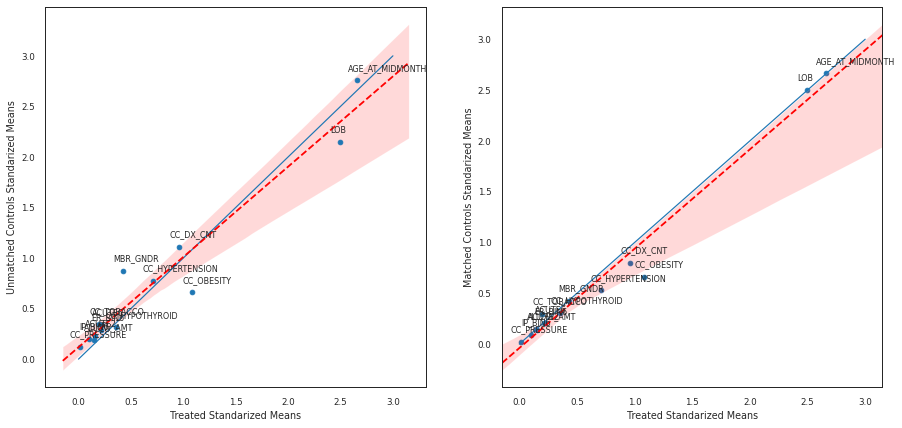

In [111]:
fig, ax = plt.subplots(1,2, figsize = (15,7))
ax[0].plot([0,3], [0, 3])
ax[1].plot([0,3], [0, 3])
ax[0].set_xlabel('Treated Standarized Means')
ax[0].set_ylabel('Unmatched Controls Standarized Means')
sns.regplot(stdMeans['Treated'].values, stdMeans['Controls'].values,scatter = False, ax = ax[0],line_kws={"color": "red","linestyle" : '--'
})

ax[0].scatter(stdMeans['Treated'], stdMeans['Controls'])
ax[1].scatter(stdMeans['Treated'], stdMeans['MControls'])
ax[1].set_xlabel('Treated Standarized Means')
ax[1].set_ylabel('Matched Controls Standarized Means')
sns.regplot(stdMeans['Treated'].values, stdMeans['MControls'].values, scatter = False,ax = ax[1], line_kws={"color": "red","linestyle" : '--'
})
for i, name in enumerate(list(stdMeans.index)):
    ax[0].annotate(name, (stdMeans['Treated'].iloc[i],stdMeans['Controls'].iloc[i]), fontsize = 'small',
                   textcoords = 'offset points',xytext = (-10,10))
    ax[1].annotate(name, (stdMeans['Treated'].iloc[i],stdMeans['MControls'].iloc[i]),fontsize = 'small',
                   textcoords = 'offset points', xytext = (-10,10))

fig.savefig(result_base+"figures/std_means_graph.png")
fig.show()

# Ratio Stats

In [112]:
disease_cols = [cols for cols in treated.columns if "CC" in cols and cols!='CC_DX_CNT']
other_binary_cols = ['MBR_GNDR', 'LOB', 'PREGNANCY', 'IP_BIN', 'ER_BIN', 'ACUTE']
binary_cols = other_binary_cols + disease_cols 
restricted_cols = ['PERS_ID', 'MYR', 'MEDICAID_LOB']
continuous_cols = [cols for cols in treated.columns if cols not in binary_cols + restricted_cols]

In [113]:
def calculate_continuous_d(t, c):
    Xt = np.mean(t)
    Xc = np.mean(c)
    St = np.std(t)
    Sc = np.std(c)
    d = np.abs((Xt-Xc)/(np.sqrt((St**2 + Sc**2)/2)))
    return d

In [114]:
def calculate_binary_d(t, c):
    Pt = np.mean(t)
    Pc = np.mean(c)
    d = np.abs((Pt-Pc)/(np.sqrt((Pt*(1-Pt)+Pc*(1-Pc))/2)))
    return d

In [115]:
d_metric_before = pd.DataFrame()
for col in treated.columns.tolist():
    if col not in restricted_cols:
        if col in binary_cols:
            d = calculate_binary_d(treated_original[[col]].values, controls_original[[col]].values)
        elif col in continuous_cols:
            d = calculate_continuous_d(treated_original[[col]].values, controls_original[[col]].values)
        d_metric_before.loc[0,col] = d

In [116]:
d_metric_before

MBR_GNDR  AGE_AT_MIDMONTH  ALLOW_AMT  ALLOW_ER  ALLOW_IP   CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS    CC_AMI  CC_ANEMIA  CC_ANXIETY_DISORDER  CC_ARTHRITIS  CC_ASTHMA  CC_ATRIAL_FIB  CC_AUTISM  CC_BIPOLAR    CC_BPH  CC_BREAST_CANCER  CC_CATARACT  CC_CEREBRAL_PALSY  CC_CHRONIC_KIDNEY  CC_COLORECTAL_CANCER   CC_COPD  CC_CYSTIC_FIBROSIS  CC_DEPRESSION  CC_DEPRESSIVE_DISORDERS  CC_DEVELOP_DELAYS  CC_DIABETES  CC_DISAB_DX_CNT  CC_DX_CNT  CC_ENDOMETRIAL_CANCER  CC_EPILEPSY  CC_FIBROMYALGIA  CC_GLAUCOMA  CC_HEARING_IMPAIR  CC_HEART_FAILURE  CC_HEPATITIS_A  CC_HEPATITIS_B_ACUTE  CC_HEPATITIS_B_CHRONIC  CC_HEPATITIS_C_ACUTE  CC_HEPATITIS_C_CHRONIC  CC_HEPATITIS_C_UNSPECIFIED  CC_HEPATITIS_D  CC_HEPATITIS_E  CC_HEPATITIS_GEN  CC_HIP_FRACTURE  CC_HYPERLIPIDEMIA  CC_HYPERTENSION  CC_HYPOTHYROID  CC_INT_DISAB  CC_ISCHEMIC  CC_LEARN_DISAB  CC_LEUKEMIAS  CC_LIVER  CC_LUNG_CANCER  CC_MIGRAINE  CC_MOBILITY_IMPAIR  CC_MULTIPLE_SCLEROSIS  CC_MUSCULAR_DYSTROPHY  CC_OBESITY  CC_OSTEOPOROSIS  \
0  0.530358         0.092488   0.019968  0.006935  0.022286  0.035068      0.125096           0.208282  0.052591   0.061091              0.11784      0.005917   0.077033       0.154677   0.094578     0.02979  0.152311          0.070428     0.071426           0.014078           0.295809              0.048167  0.141256            0.028147       0.070037                 0.061804           0.055776     0.440549         0.133245   0.116179               0.013681     0.054492         0.004089     0.071661           0.074579          0.141264        0.014046              0.001303                0.019057               0.02396                0.064657                    0.044344        0.005492        0.004042          0.067846         0.061257            0.13576         0.090343        0.028193      0.068473      0.19364        0.055275      0.012445  0.028532        0.048134     0.177036            0.061717               0.065727               0.030017    0.478547         0.087685   

   CC_PERIPHERAL  CC_PERSONALITY  CC_PRESSURE  CC_PROSTATE_CANCER   CC_PTSD  CC_SCHIZOPHRENIA  CC_SCHIZOPHRENIA_OTHER  CC_SPINAL_CORD  CC_SPINA_BIFIDA  CC_STROKE  CC_TOBACCO  CC_TRAUMATIC_BRAIN  CC_VISUAL_IMPAIR       LOB  PREGNANCY    IP_BIN    ER_BIN     ACUTE    IP_C    ER_C   ACUTE_C   IP_BIN6   ER_BIN6    ACUTE6   IP_BIN2   ER_BIN2    ACUTE2  HasPast  
0       0.203177        0.004622     0.133538            0.100294  0.044208          0.087072                0.120822        0.049509         0.006304   0.061793    0.155144            0.008416          0.047475  0.435424    0.03231  0.069515  0.064048  0.086992  0.0769  0.0074  0.017141  0.137075  0.112263  0.154748  0.092436  0.081752  0.111771  0.23801

In [117]:
d_metric_before.T.to_csv(result_base+"stats_matching/d_metric_before.csv", header=True, index=True)

In [118]:
d_metric_before.T[d_metric_before.T[0]<0.1].size

62

In [119]:
d1 = d_metric_before.loc[:,:'LOB']

In [120]:
d1

MBR_GNDR  AGE_AT_MIDMONTH  ALLOW_AMT  ALLOW_ER  ALLOW_IP   CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS    CC_AMI  CC_ANEMIA  CC_ANXIETY_DISORDER  CC_ARTHRITIS  CC_ASTHMA  CC_ATRIAL_FIB  CC_AUTISM  CC_BIPOLAR    CC_BPH  CC_BREAST_CANCER  CC_CATARACT  CC_CEREBRAL_PALSY  CC_CHRONIC_KIDNEY  CC_COLORECTAL_CANCER   CC_COPD  CC_CYSTIC_FIBROSIS  CC_DEPRESSION  CC_DEPRESSIVE_DISORDERS  CC_DEVELOP_DELAYS  CC_DIABETES  CC_DISAB_DX_CNT  CC_DX_CNT  CC_ENDOMETRIAL_CANCER  CC_EPILEPSY  CC_FIBROMYALGIA  CC_GLAUCOMA  CC_HEARING_IMPAIR  CC_HEART_FAILURE  CC_HEPATITIS_A  CC_HEPATITIS_B_ACUTE  CC_HEPATITIS_B_CHRONIC  CC_HEPATITIS_C_ACUTE  CC_HEPATITIS_C_CHRONIC  CC_HEPATITIS_C_UNSPECIFIED  CC_HEPATITIS_D  CC_HEPATITIS_E  CC_HEPATITIS_GEN  CC_HIP_FRACTURE  CC_HYPERLIPIDEMIA  CC_HYPERTENSION  CC_HYPOTHYROID  CC_INT_DISAB  CC_ISCHEMIC  CC_LEARN_DISAB  CC_LEUKEMIAS  CC_LIVER  CC_LUNG_CANCER  CC_MIGRAINE  CC_MOBILITY_IMPAIR  CC_MULTIPLE_SCLEROSIS  CC_MUSCULAR_DYSTROPHY  CC_OBESITY  CC_OSTEOPOROSIS  \
0  0.530358         0.092488   0.019968  0.006935  0.022286  0.035068      0.125096           0.208282  0.052591   0.061091              0.11784      0.005917   0.077033       0.154677   0.094578     0.02979  0.152311          0.070428     0.071426           0.014078           0.295809              0.048167  0.141256            0.028147       0.070037                 0.061804           0.055776     0.440549         0.133245   0.116179               0.013681     0.054492         0.004089     0.071661           0.074579          0.141264        0.014046              0.001303                0.019057               0.02396                0.064657                    0.044344        0.005492        0.004042          0.067846         0.061257            0.13576         0.090343        0.028193      0.068473      0.19364        0.055275      0.012445  0.028532        0.048134     0.177036            0.061717               0.065727               0.030017    0.478547         0.087685   

   CC_PERIPHERAL  CC_PERSONALITY  CC_PRESSURE  CC_PROSTATE_CANCER   CC_PTSD  CC_SCHIZOPHRENIA  CC_SCHIZOPHRENIA_OTHER  CC_SPINAL_CORD  CC_SPINA_BIFIDA  CC_STROKE  CC_TOBACCO  CC_TRAUMATIC_BRAIN  CC_VISUAL_IMPAIR       LOB  
0       0.203177        0.004622     0.133538            0.100294  0.044208          0.087072                0.120822        0.049509         0.006304   0.061793    0.155144            0.008416          0.047475  0.435424

In [121]:
d1.T[d1.T[0]<0.1].size

53

In [122]:
d_metric_after = pd.DataFrame()
for col in treated.columns.tolist():
    if col not in restricted_cols:
        if col in binary_cols:
            d = calculate_binary_d(treated_original[[col]].values, matched_controls_original[[col]].values)
        elif col in continuous_cols:
            d = calculate_continuous_d(treated_original[[col]].values, matched_controls_original[[col]].values)
        d_metric_after.loc[0,col] = d

In [123]:
d_metric_after.T.to_csv(result_base+"stats_matching/d_metric_after.csv", header=True, index=True)

In [124]:
d_metric_after.T[d_metric_after.T[0]<0.1].size

80

In [125]:
d2 = d_metric_after.loc[:,:'LOB']

In [126]:
d2.T[d2.T[0]<0.1].size

67

In [127]:
ratio = d_metric_after/d_metric_before
ratio

MBR_GNDR  AGE_AT_MIDMONTH  ALLOW_AMT  ALLOW_ER  ALLOW_IP   CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS    CC_AMI  CC_ANEMIA  CC_ANXIETY_DISORDER  CC_ARTHRITIS  CC_ASTHMA  CC_ATRIAL_FIB  CC_AUTISM  CC_BIPOLAR    CC_BPH  CC_BREAST_CANCER  CC_CATARACT  CC_CEREBRAL_PALSY  CC_CHRONIC_KIDNEY  CC_COLORECTAL_CANCER   CC_COPD  CC_CYSTIC_FIBROSIS  CC_DEPRESSION  CC_DEPRESSIVE_DISORDERS  CC_DEVELOP_DELAYS  CC_DIABETES  CC_DISAB_DX_CNT  CC_DX_CNT  CC_ENDOMETRIAL_CANCER  CC_EPILEPSY  CC_FIBROMYALGIA  CC_GLAUCOMA  CC_HEARING_IMPAIR  CC_HEART_FAILURE  CC_HEPATITIS_A  CC_HEPATITIS_B_ACUTE  CC_HEPATITIS_B_CHRONIC  CC_HEPATITIS_C_ACUTE  CC_HEPATITIS_C_CHRONIC  CC_HEPATITIS_C_UNSPECIFIED  CC_HEPATITIS_D  CC_HEPATITIS_E  CC_HEPATITIS_GEN  CC_HIP_FRACTURE  CC_HYPERLIPIDEMIA  CC_HYPERTENSION  CC_HYPOTHYROID  CC_INT_DISAB  CC_ISCHEMIC  CC_LEARN_DISAB  CC_LEUKEMIAS  CC_LIVER  CC_LUNG_CANCER  CC_MIGRAINE  CC_MOBILITY_IMPAIR  CC_MULTIPLE_SCLEROSIS  CC_MUSCULAR_DYSTROPHY  CC_OBESITY  CC_OSTEOPOROSIS  \
0  0.003401          0.30586   1.203846  0.993226  0.065714  2.082936      0.379523           0.408864  0.368316   0.252696             0.363146      6.022025   1.201344       0.028199   0.174728    0.486001  0.102724          0.548864      0.32544           2.748481           0.099534              0.167877  0.015118            0.962864       0.913211                 0.106001           0.585671     0.400151         0.082819   1.629358               0.583455     0.398055          4.15397     0.161298           0.066005          0.162165        0.707501              6.887362                0.820261                   NaN                0.060662                    0.273559             NaN             NaN          0.013631         0.332497           0.586583         1.600024         0.41865       0.42714     0.064194        0.531039      1.569636  1.162571        0.357389     0.474665            0.211351               0.407492               1.127871    0.835253         0.740872   

   CC_PERIPHERAL  CC_PERSONALITY  CC_PRESSURE  CC_PROSTATE_CANCER   CC_PTSD  CC_SCHIZOPHRENIA  CC_SCHIZOPHRENIA_OTHER  CC_SPINAL_CORD  CC_SPINA_BIFIDA  CC_STROKE  CC_TOBACCO  CC_TRAUMATIC_BRAIN  CC_VISUAL_IMPAIR       LOB  PREGNANCY    IP_BIN    ER_BIN     ACUTE      IP_C      ER_C   ACUTE_C   IP_BIN6   ER_BIN6    ACUTE6   IP_BIN2   ER_BIN2    ACUTE2   HasPast  
0       0.031306        2.368078     0.177763            0.154913  0.543081          0.330868                0.472544        0.103525          4.24708   0.198873    0.712554             0.39755          0.460311  0.011913     0.7042  0.152573  0.017938  0.060356  0.357641  3.478023  1.946882  0.113761  0.061701  0.000142  0.152124  0.004697  0.046633  0.747553

In [128]:
ratio.T[ratio.T[0]>=1.0].size

16

In [129]:
ratio.T.to_csv(result_base+"stats_matching/ratio.csv", header=True, index=True)

In [130]:
!aws s3 cp ./Final/Data/MHTM_g s3://cdphp-s3-us-e-p-pond/rpi/nneehal/DATA/CanaryPaper/MHTM_g --recursive --acl bucket-owner-full-control

upload: Final/Data/MHTM_g/matched0.p to s3://cdphp-s3-us-e-p-pond/rpi/nneehal/DATA/CanaryPaper/MHTM_g/matched0.p
upload: Final/Data/MHTM_g/matched_controls_latent_from_algo.p to s3://cdphp-s3-us-e-p-pond/rpi/nneehal/DATA/CanaryPaper/MHTM_g/matched_controls_latent_from_algo.p
upload: Final/Data/MHTM_g/matched_controls_aggregate.p to s3://cdphp-s3-us-e-p-pond/rpi/nneehal/DATA/CanaryPaper/MHTM_g/matched_controls_aggregate.p
upload: Final/Data/MHTM_g/matched_controls_original.p to s3://cdphp-s3-us-e-p-pond/rpi/nneehal/DATA/CanaryPaper/MHTM_g/matched_controls_original.p
upload: Final/Data/MHTM_g/matched_controls_latent_after_process.p to s3://cdphp-s3-us-e-p-pond/rpi/nneehal/DATA/CanaryPaper/MHTM_g/matched_controls_latent_after_process.p
upload: Final/Data/MHTM_g/controls_all.p to s3://cdphp-s3-us-e-p-pond/rpi/nneehal/DATA/CanaryPaper/MHTM_g/controls_all.p
